**IMDb**（Internet Movie Datebase ）是全球最大的互联网影视数据库，而[Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) 是一个根据IMDB上电影评论而建立的数据集。它由斯坦福大学于 2011 年发布。

![image-20201226152702981](images/image-20201226152702981.png)

## 获取数据

首先引入需要的包。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf

from collections import Counter
from scipy import stats
from sklearn.feature_extraction import text
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

base_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/code'
sys.path.append(base_path)

from text_classification import set_gpu_memory, lr_schedule, ngram_vectorize, sequence_vectorize, show_tree
from text_classification import plot_distribution, plot_length_distribution, plot_frequency_distribution
from text_classification import DictToObject, TextClassificationHelper
from text_classification import SimpleTextDataset, SequenceTextDataset

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

设置GPU最大内存。

In [3]:
set_gpu_memory(1024)
model_results={}

set max gpu memory to 1024


初始化参数。

In [4]:
params = {
    'dataset_name': 'stack_overflow_16k',
    'sample_perecent': 1,    
    'classes': ['csharp', 'java', 'javascript', 'python'],
    'validation_percent': 0.0,     
    'batch_size': 32,    
    'max_features': 20000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'restore_best_checkpoint':True,
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':20},
        'rnn':{'dropout':0.3, 'embedding_dim':200, 'units':200, 'epochs':5},
        'embedding':{'dropout':0.2, 'embedding_dim':200, 'epochs':10},
        'sepcnn':{'dropout':0.4, 'epochs': 10, 'batch_size':128},
    }
}

params = DictToObject(params)

### 下载数据

开始下载数据。

In [5]:
dataset_dir =  os.path.join(os.path.expanduser('~'), '.keras/datasets/stack_overflow_16k') 
if not os.path.exists(dataset_dir):
    url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
    dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url, untar=True, 
                                      cache_subdir='datasets/stack_overflow_16k')
print(dataset_dir)

/root/.keras/datasets/stack_overflow_16k


In [6]:
show_tree(dataset_dir, max_depth=2)

/root/.keras/datasets/stack_overflow_16k
├──stack_overflow_16k.tar.gz.tar.gz
├──README.md
├──train
│   ├──python
│   ├──java
│   ├──csharp
│   └──javascript
└──test
    ├──python
    ├──java
    ├──csharp
    └──javascript


![image-20201217095446441](images/image-20201217095446441.png)

下面是压缩文件解开后的目录结构。

![image-20201104115404253](images/image-20201104115404253.png)

其中train和test目录包含了实际的文本数据，详细说明见[IMDB](https://eipi10.cn/others/2020/10/22/dataset/#imdb---large-movie-review-dataset)。

### 查看数据

下面看一看实际的数据是啥样的。

In [7]:
def get_files(base_dir):
    files = {}
    for folder in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, folder)
        text_files = os.listdir(class_dir)
        files[folder] = [os.path.join(class_dir, file_name) for file_name in text_files]    
    return files

def show_files(files, title=''):
    print('-'*40, title, '-'*40)
    for class_dir, text_files in files.items():
        print('{}: {} files'.format(class_dir, len(text_files)))
        

train_files = get_files(os.path.join(dataset_dir, 'train'))
test_files = get_files(os.path.join(dataset_dir, 'test'))    
    
show_files(train_files, 'train')
show_files(test_files, 'test')

---------------------------------------- train ----------------------------------------
python: 2000 files
java: 2000 files
csharp: 2000 files
javascript: 2000 files
---------------------------------------- test ----------------------------------------
python: 2000 files
java: 2000 files
csharp: 2000 files
javascript: 2000 files


![image-20201217115036617](images/image-20201217115036617.png)

首先看一看正面的评论。

In [8]:
for class_dir, text_files in train_files.items():
    print('='*40, class_dir, '='*40)
    for file_path in text_files[0:2]:    
        print('-'*30 + os.path.basename(file_path) + '-'*30 )
        with open(file_path) as f:
            comment = f.read() 
            print(comment if len(comment)<=800 else comment[0:800]+' ...') 

======================================== python ========================================
------------------------------1053.txt------------------------------
"how to put multiple pickles files in a single pickle file i have two pickle files that are contain a list of numpy ndarrays...first pickle file:..{'encodings': [array([-0.18668848,  0.09167872,  0.02361359, -0.04610855, -0.11987427,.       -0.06734911,  0.00542389,  0.02105863,  0.17828396, -0.00141097,.        0.166828s45, -0.01075029, -0.20508201,  0.02762154, -0.00806585,.        0.098497  , -0.17736666, -0.11334869, -0.10142692, -0.1134191 ,.        0.06917755,  0.07989676, -0.04121129,  0.04280601, -0.12306173,.       -0.29819348, -0.07650399, -0.10041754,  0.02334423, -0.06270325,.        0.12638046,  0.10296188, -0.10587093, -0.08311734,  0.06213638,.        0.08304631, -0.03443629, -0.08486824,  0.23685798,  0.01827276,.       -0.10278646,  0.01152256,  0.08467054,  0.37257931,  0 ...
------------------------------1735.tx

![image-20201217111649607](images/image-20201217111649607.png)

然后看一看负面的评论。



## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [9]:
dataset_dir

'/root/.keras/datasets/stack_overflow_16k'

In [10]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    

def load_stack_overflow_16k_dataset(data_path, classes=params.classes, seed=123):
    def load_data(base_dir):
        texts = []
        labels = []
        for category in os.listdir(base_dir):
            category_path = os.path.join(base_dir, category)
            for fname in sorted(os.listdir(category_path)):
                if fname.endswith('.txt'):
                    with open(os.path.join(category_path, fname)) as f:
                        texts.append(f.read())
                    labels.append(classes.index(category) )
        return texts, labels

    train_texts, train_labels = load_data(os.path.join(data_path, 'train'))
    test_texts, test_labels = load_data(os.path.join(data_path, 'test'))

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

(train_texts, train_labels), (test_texts, test_labels) = load_stack_overflow_16k_dataset(dataset_dir)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=8000, train_labels.shape=(8000,)
test_texts.length=8000, test_labels.shape=(8000,)
train_texts.length=8000, train_labels.shape=(8000,)
test_texts.length=8000, test_labels.shape=(8000,)


In [56]:
test_texts[0]

'"variables keep changing back to their original value inside a while loop i am doing the mitx 6.00.01x course and i am on the second problem set on the 3rd problem and i am stuck. .my code:  ..    balance = 320000.    annualinterestrate = 0.2.    monthlyinterestrate = (annualinterestrate) / 12.0.    monthlyfixedpayment = 0.    empbalance = balance.    lowerbound = round((balance)/12,2).    upperbound = (balance*(1+monthlyinterestrate)**12)/12.    monthlyfixedpayment = round( ( (lowerbound+upperbound)/2) ,2).    while tempbalance != 0: .        monthlyfixedpayment = round( ( (lowerbound+upperbound)/2) ,2)  .        for m in range(12) :.            tempbalance -= monthlyfixedpayment .            tempbalance += (monthlyinterestrate)*(tempbalance).            tempbalance = round(tempbalance,2) .        if tempbalance &gt; 0:.            lowerbound = round(monthlyfixedpayment,2).            tempbalance = balance.        elif tempbalance &lt; 0: .            upperbound = round(monthlyfixedp

![image-20201217122349480](images/image-20201217122349480.png)

### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

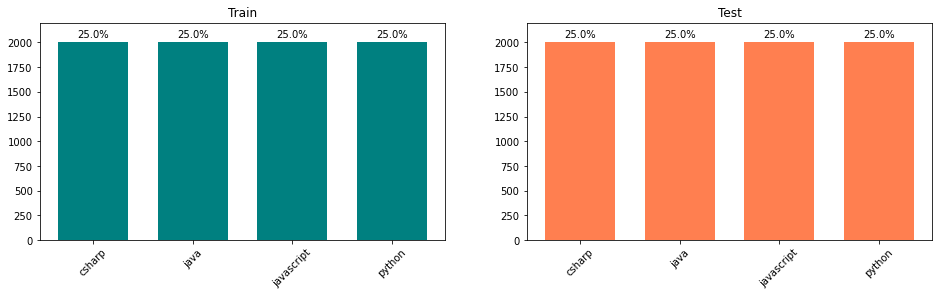

In [11]:
plot_distribution(train_labels, test_labels, params.classes)

![image-20201217123826241](images/image-20201217123826241.png)

### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

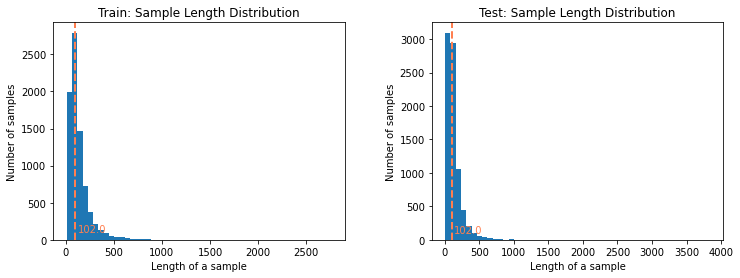

train：mean=137.06 variance=16491.97
test：mean=133.22 variance=14516.98


In [12]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))

![image-20210101163434402](images/image-20210101163434402.png)

通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [13]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3868,2836,772,283,113,54,36,12,26,8000
train,3885,2742,782,295,131,68,38,22,37,8000
合计,7753,5578,1554,578,244,122,74,34,63,16000


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3876.5,2789.0,777.0,289.0,122.0,61.0,37.0,17.0,31.5,8000.0
train,3876.5,2789.0,777.0,289.0,122.0,61.0,37.0,17.0,31.5,8000.0
合计,7753.0,5578.0,1554.0,578.0,244.0,122.0,74.0,34.0,63.0,16000.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [14]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 9.785132895960267
critical_value = 15.50731305586545
p_value = 0.2804318778573175


![image-20210101174317709](images/image-20210101174317709.png)

### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

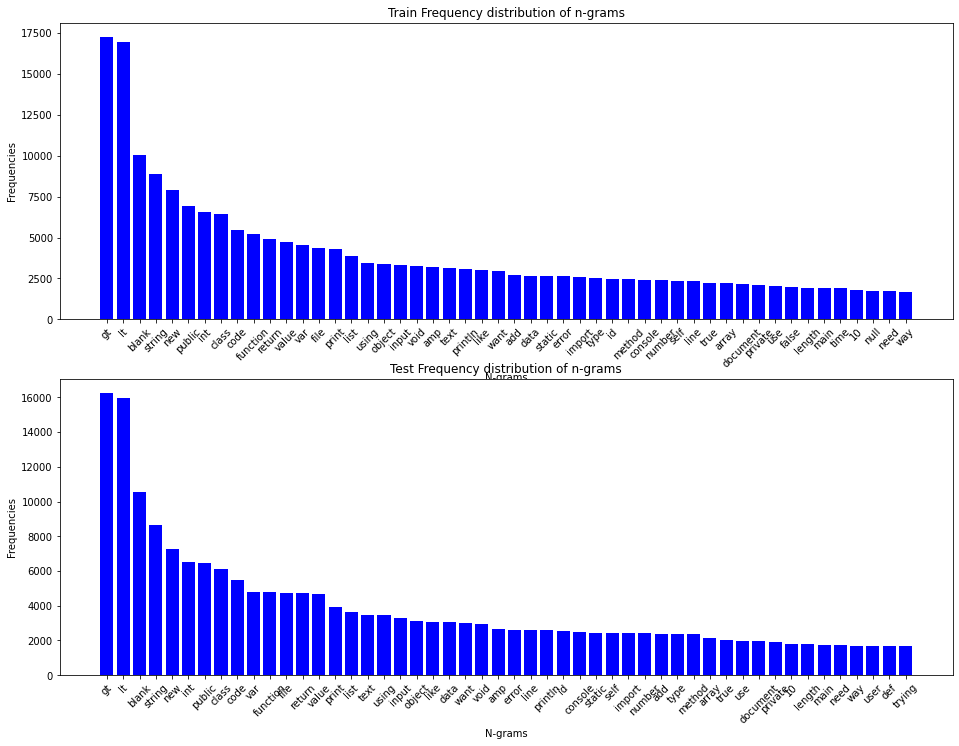

In [15]:
plot_frequency_distribution(train_texts, test_texts)

![image-20201217134151280](images/image-20201217134151280.png)

In [16]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 337733
Number of Vocabulary: 4670


![image-20201217142728260](images/image-20201217142728260.png)

上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [17]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 78.4


![image-20201217144321430](images/image-20201217144321430.png)

可以看到这个比例大大小于143.7，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下两个过程。

- Tokenization：把文本转化成Token
- Vectorization： 把Token变成Vector

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [18]:
train_ngram, test_ngram, token_vectorizer = ngram_vectorize(train_texts, train_labels, test_texts, 
                                                            top_k=params.max_features)

print(train_ngram.shape, type(train_ngram), train_ngram.dtype)
print(test_ngram.shape, type(test_ngram), test_ngram.dtype)
print(train_ngram[0, 0:1000])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1799: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


(8000, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
(8000, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 570)	0.020662328
  (0, 686)	0.023207309
  (0, 804)	0.015023412
  (0, 815)	0.032113217
  (0, 850)	0.014628538
  (0, 901)	0.03103171


![image-20210102091446193](images/image-20210102091446193.png)

可以看到上面数据是以稀疏矩阵的形式存在的。下面创建ngram数据集。

In [19]:
ngram_data = SimpleTextDataset(params, train_ngram, train_labels, test_ngram, test_labels, train_texts, test_texts)

create train, validation and test dataset


### Sequence

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。下面将采用两种方式生成Sequence向量。

- Tokenizer
- TextVectorization

#### Tokenizer

In [20]:
train_seq, test_seq, tokenizer_seq = sequence_vectorize(train_texts, test_texts, 
                                                        top_k=params.max_features,
                                                        max_sequence_length =params.sequence_length
                                                       )

print(train_seq.shape, type(train_seq), train_seq.dtype)
print(test_seq.shape, type(test_seq), test_seq.dtype)
print(test_seq[0][0:500])

(8000, 500) <class 'numpy.ndarray'> int32
(8000, 500) <class 'numpy.ndarray'> int32
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

![image-20210102105418015](images/image-20210102105418015.png)

创建sequence数据集。

In [21]:
sequence_data = SequenceTextDataset(params, train_seq, train_labels, test_seq, test_labels, 
                                    train_texts, test_texts, tokenizer_seq)

create train, validation and test dataset


#### TextVectorization

下面直接从原始的文件读入数据，删除无用的目录。

In [22]:
train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(train_dir))
remove_dir = os.path.join(train_dir, 'unsup')
if os.path.exists(remove_dir): shutil.rmtree(remove_dir)
print(os.listdir(train_dir))

['python', 'java', 'csharp', 'javascript']
['python', 'java', 'csharp', 'javascript']


![image-20210102102355896](images/image-20210102102355896.png)

把数据下载进dataset。

In [23]:
batch_size = params.batch_size
validation_split = params.validation_percent
seed = 42

if validation_split>0:
    raw_train_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size, 
        validation_split=validation_split,
        subset='training', 
        seed=seed)

    print('-'*100)
    raw_val_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size, 
        validation_split=validation_split,
        subset='validation', 
        seed=seed)    
    
else:
    print('-'*100)
    raw_train_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size)
    raw_val_seq_ds = None


print('-'*100)
raw_test_seq_ds = preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'test'), 
    batch_size=batch_size)

for text_batch, label_batch in raw_train_seq_ds.take(1):
    for i in range(3):
        print('-'*50, label_batch.numpy()[i], '-'*50)
        print(text_batch.numpy()[i])
        
print('-'*100)
print("Label 0 corresponds to", raw_train_seq_ds.class_names[0])
print("Label 1 corresponds to", raw_train_seq_ds.class_names[1])       

----------------------------------------------------------------------------------------------------
Found 8000 files belonging to 4 classes.
----------------------------------------------------------------------------------------------------
Found 8000 files belonging to 4 classes.
-------------------------------------------------- 3 --------------------------------------------------
b'"get reference of function inside function for usage in prototype/creation function i have two nested functions: the outer creates a creation method / prototype, the inner will create a concrete example of that prototype:..class example:.    def __init__(self, str):.        self.str = str..def make_prototype(proto_name):.    def make_example(example_name):.        return example(proto_name + \' \' + example_name).    return make_example..proto = make_prototype(\'prototype 1\').ex1 = proto(\'example 1\')...now, i\'d like to remember the used creation function in the example. i did it the following way:..

![image-20210102102702043](images/image-20210102102702043.png)

然后把进行Vectorization。

In [24]:
max_features = params.max_features
sequence_length = params.sequence_length

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_seq_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

print("7 ---> ",vectorize_layer.get_vocabulary()[7])
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

7 --->  in
1287 --->  equivalent
 313 --->  must
Vocabulary size: 20000


![image-20210102105650161](images/image-20210102105650161.png)

然后生成具体的train，validation，test数据集。

In [25]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_seq_ds = raw_train_seq_ds.map(vectorize_text)
if raw_val_seq_ds is not None:
    val_seq_ds = raw_val_seq_ds.map(vectorize_text)
else:
    val_seq_ds = None
test_seq_ds = raw_test_seq_ds.map(vectorize_text)

# cache data to improve the performance
train_seq_ds = train_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
if val_seq_ds is not None: 
    val_seq_ds = val_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_seq_ds = test_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 查看数据
vector_batch, label_batch = next(iter(train_seq_ds))
first_vector, first_label = vector_batch[0], label_batch[0]

print('Label：{}'.format(params.classes[first_label]))
print('-'*40, 'Vector', '-'*40)
print(first_vector.numpy())
print('-'*40, 'orginal review', '-'*40)
print(' '.join([vectorize_layer.get_vocabulary()[v] for v in first_vector]))

Label：javascript
---------------------------------------- Vector ----------------------------------------
[ 417 1166  417 6760  344   13    1    5 7765 2306  417 9598    1  417
 9598    1   10  419    7   89    6   67   75  408    7  278  656  317
    4   83    1    7   23  211  272    3   17  354  205 1166 2306  417
 4297  330    4  187  130    7  526 9544    3  102   14   13    6   21
  428   85   36   83   51  448   33  417  433   49   23  623   72 1689
    3   92   17  205 6760   26    3   35  222   14  132   51   72   33
  417   34    3   70 1166 2306  417    7  528    9 6760   45   92    3
  166   73   23 1166   22 6760    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  

![image-20210102141537073](images/image-20210102141537073.png)

![image-20210102141609143](images/image-20210102141609143.png)

##  模型

### MLP

In [26]:
def sparse_to_dense(value):
    if isinstance(value, tf.sparse.SparseTensor):
        return tf.sparse.to_dense(value)
    return value

def get_mlp(helper, dropout=None, name='mlp'):
    """Creates an instance of a multi-layer perceptron model"""
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    layer_count = helper.get_model_param(name, 'layer_count')
    units = helper.get_model_param(name, 'units')    
    
    input = layers.Input(shape=helper.data.input_shape)    
    x = tf.keras.layers.Lambda(sparse_to_dense)(input)
    if dropout>0: x = layers.Dropout(dropout)(x)
        
    for _ in range(layer_count):
        x = layers.Dense(units, activation='relu')(x)
        if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    
    model = Model(inputs=input, outputs=x, name=name)     
    helper.compile(model)   
    return model

helper = TextClassificationHelper(params, model_results=model_results, data=ngram_data)
model = get_mlp(helper)
model.summary()

model_params.mlp.dropout=0.6
model_params.mlp.layer_count=1
model_params.mlp.units=256
learning_rate=0.001
checkpoint_path=./checkpoints/stack_overflow_16k/mlp/checkpoint
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
lambda (Lambda)              (None, 20000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5120256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)         

2021-01-05 02:08:05,090: INFO: start training


model_params.mlp.epochs=20
use ModelCheckpoint(filepath=./checkpoints/stack_overflow_16k/mlp/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/20
250/250 [==============================] - 2s 7ms/step - loss: 0.9748 - accuracy: 0.6841 - val_loss: 0.5404 - val_accuracy: 0.8587
Epoch 2/20
250/250 [==============================] - 2s 6ms/step - loss: 0.4870 - accuracy: 0.8406 - val_loss: 0.3732 - val_accuracy: 0.8813
Epoch 3/20
250/250 [==============================] - 2s 6ms/step - loss: 0.3654 - accuracy: 0.8731 - val_loss: 0.3325 - val_accuracy: 0.8839
Epoch 4/20
250/250 [==============================] - 2s 6ms/step - loss: 0.3058 - accuracy: 0.8945 - val_loss: 0.3100 - val_accuracy: 0.8855
Epoch 5/20
250/250 [==============================] - 2s 6ms/step - loss: 0.2612 - accuracy: 0.9104 - val_loss: 0.3003 - val_accuracy: 0.8906
E

2021-01-05 02:08:36,053: INFO: finish training [elapsed time: 30.96 seconds]


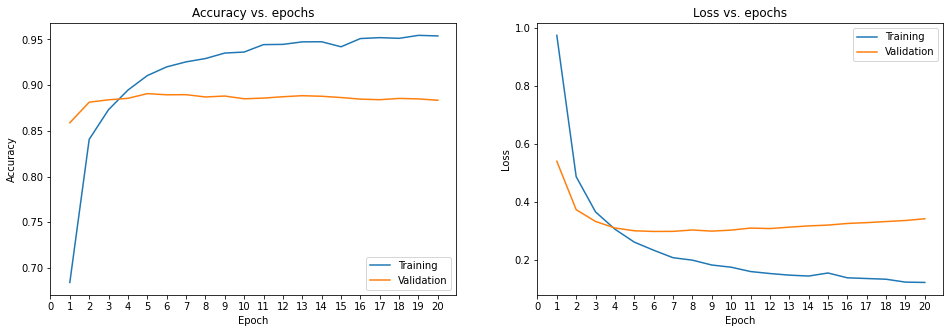

In [27]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
250/250 [==============================] - 1s 2ms/step - loss: 0.3003 - accuracy: 0.8906
Test loss:0.3003, Test Accuracy:89.06%
---------------------------------------- confusion matrix ----------------------------------------
250/250 [==============================] - 0s 2ms/step


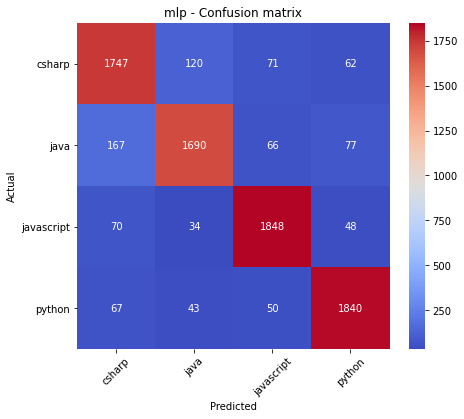

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.112182,0.9811,0.300295,0.8906,5121284,30.0


In [28]:
helper.model_summary(model, history=history)

### LSTM

In [32]:
def get_lstm(helper, name='rnn_lstm', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   

    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm(helper)
model.summary()


model_params.rnn_lstm.dropout=0.3
model_params.rnn_lstm.units=200
max_features=20000
model_params.rnn_lstm.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/stack_overflow_16k/rnn_lstm/checkpoint
Model: "rnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 804       
Total params: 4,321,804
Trainable params: 

2021-01-05 02:08:40,206: INFO: start training


model_params.rnn_lstm.epochs=5
use ModelCheckpoint(filepath=./checkpoints/stack_overflow_16k/rnn_lstm/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
250/250 [==============================] - 159s 637ms/step - loss: 1.0584 - accuracy: 0.5331 - val_loss: 0.7639 - val_accuracy: 0.6421
Epoch 2/5
250/250 [==============================] - 164s 657ms/step - loss: 0.7555 - accuracy: 0.7266 - val_loss: 0.7749 - val_accuracy: 0.6929
Epoch 3/5
250/250 [==============================] - 166s 665ms/step - loss: 0.6527 - accuracy: 0.7536 - val_loss: 0.5715 - val_accuracy: 0.7950
Epoch 4/5
250/250 [==============================] - 168s 673ms/step - loss: 0.3886 - accuracy: 0.8813 - val_loss: 0.5870 - val_accuracy: 0.8146
Epoch 5/5
250/250 [==============================] - 166s 666ms/step - loss: 0.2488 - accuracy: 0.9252 - val_loss: 0.5716 

2021-01-05 02:22:30,746: INFO: finish training [elapsed time: 830.54 seconds]


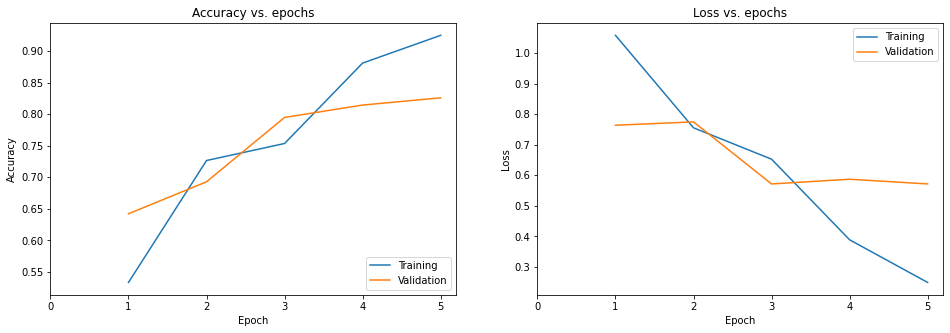

In [33]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
250/250 [==============================] - 32s 130ms/step - loss: 0.5716 - accuracy: 0.8261
Test loss:0.5716, Test Accuracy:82.61%
---------------------------------------- confusion matrix ----------------------------------------
250/250 [==============================] - 34s 137ms/step


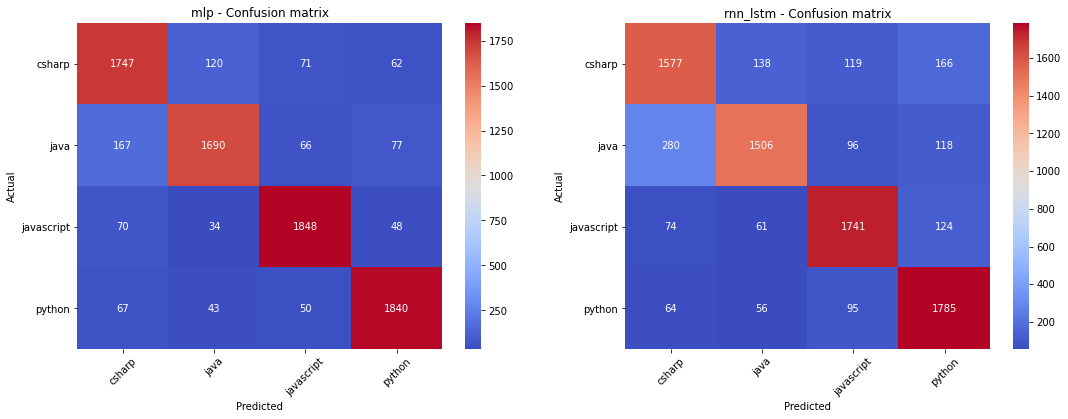

---------------------------------------- error analysis ----------------------------------------
250/250 [==============================] - 34s 136ms/step
........................................ java ........................................
"blank test class encryption is it possible to give someone your test program without giving away the logic? for example, how can the teachers give their test class that the students could use to compare their results, without actually giving the logic away of the assignment?..thanks."



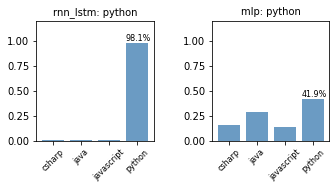

........................................ csharp ........................................
"how to create vector in blank i have a set of servers for which i need the names, but i only want those that are currently available so i need a dynamically sized array.  what data structure can i use to store these."



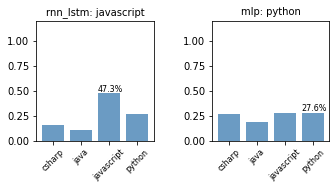

........................................ java ........................................
"generate setters only in the class constructor or generate outside builder in classes in blank, it is common (at least in college only see so) create private attributes and generate getters and setters for these attributes...but, i read that you can do something a little different: only generate the getters and leave setters in the constructor..in my head, leaving the setters in the constructor, i think the code will be easier to understand and easier to give maintenance ....do according to this second option, leave the setters in the constructor, it is good practice (or even is the best practice) to be applied in the construction of classes? or create gets and sets for all attributes is most recommended?"



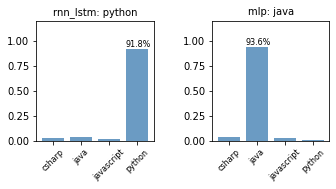

........................................ python ........................................
"difference between list and map for getting multiple user inputs what is the difference between list(int(input()).split()) and map(int,input().split()) for getting multiple inputs from user?"



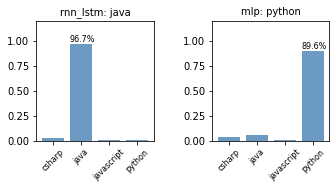

........................................ python ........................................
add web browser data to a string using blank about tab..store tab..hi i would like to know how you can extract html / webbrowser data ..so i can add it to a string



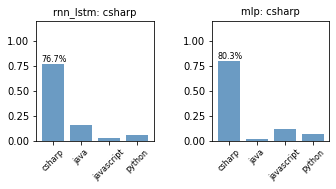

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.112182,0.9811,0.300295,0.8906,5121284,30.0
rnn_lstm,0.148746,0.9570,0.571635,0.8261,4321804,830.0


In [34]:
helper.model_summary(model, history=history)

#### LSTM + Bidirectional + Stacked

In [35]:
def get_lstm_stacked(helper, name='rnn_lstm_stacked', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   
    
    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm_stacked(helper)
model.summary()

model_params.rnn_lstm_stacked.dropout=0.3
model_params.rnn_lstm_stacked.units=200
max_features=20000
model_params.rnn_lstm_stacked.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/stack_overflow_16k/rnn_lstm_stacked/checkpoint
Model: "rnn_lstm_stacked"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 400)          641600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
__

In [36]:
# history = helper.train(model)

In [37]:
# helper.model_summary(model, history=history)

### Embedding

In [45]:
def get_embedding(helper,
                 embedding_dim=None,
                 dropout=None,
                 name='embedding'
                ):

    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    if embedding_dim is None:
        embedding_dim = helper.get_model_param(name, 'embedding_dim')        
        
    input_shape = helper.data.input_shape
    num_classes = len(helper.params.classes)
    num_features = helper.params.max_features+1  
    
    model = models.Sequential(name=name)
    model.add(layers.Embedding(input_dim=num_features,
                               output_dim=embedding_dim,
                               input_length=input_shape[0],
                               mask_zero=True))
    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(num_classes))
    helper.compile(model)  
    return model


helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_embedding(helper)
model.summary()

model_params.embedding.dropout=0.2
model_params.embedding.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/stack_overflow_16k/embedding/checkpoint
Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
global_average_pooling1d_3 ( (None, 200)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 804       
Total params: 4,001,004
Trainable params: 4,001,004
Non-trainable params: 0
_________________________________________________________________


2021-01-05 03:15:09,807: INFO: start training


model_params.embedding.epochs=10
use ModelCheckpoint(filepath=./checkpoints/stack_overflow_16k/embedding/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/10
250/250 [==============================] - 6s 24ms/step - loss: 1.1211 - accuracy: 0.6691 - val_loss: 0.7752 - val_accuracy: 0.7990
Epoch 2/10
250/250 [==============================] - 6s 24ms/step - loss: 0.5719 - accuracy: 0.8503 - val_loss: 0.4952 - val_accuracy: 0.8421
Epoch 3/10
250/250 [==============================] - 6s 23ms/step - loss: 0.3589 - accuracy: 0.9068 - val_loss: 0.4124 - val_accuracy: 0.8594
Epoch 4/10
250/250 [==============================] - 6s 24ms/step - loss: 0.2554 - accuracy: 0.9376 - val_loss: 0.3802 - val_accuracy: 0.8680
Epoch 5/10
250/250 [==============================] - 6s 24ms/step - loss: 0.1906 - accuracy: 0.9590 - val_loss: 0.3682 - val_a

2021-01-05 03:16:10,058: INFO: finish training [elapsed time: 60.25 seconds]


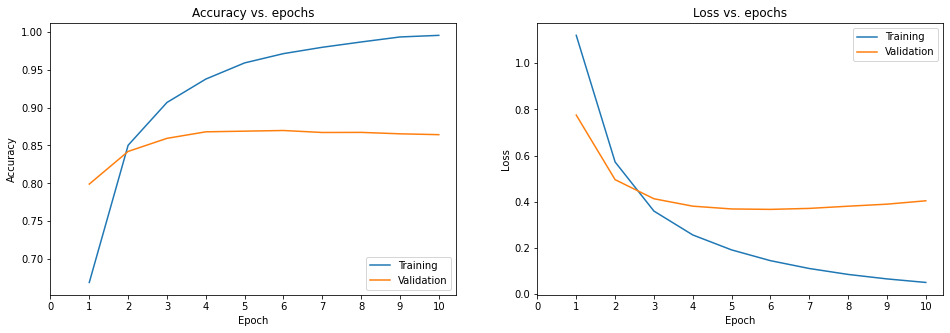

In [46]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
250/250 [==============================] - 1s 3ms/step - loss: 0.3663 - accuracy: 0.8698
Test loss:0.3663, Test Accuracy:86.98%
---------------------------------------- confusion matrix ----------------------------------------
250/250 [==============================] - 1s 3ms/step


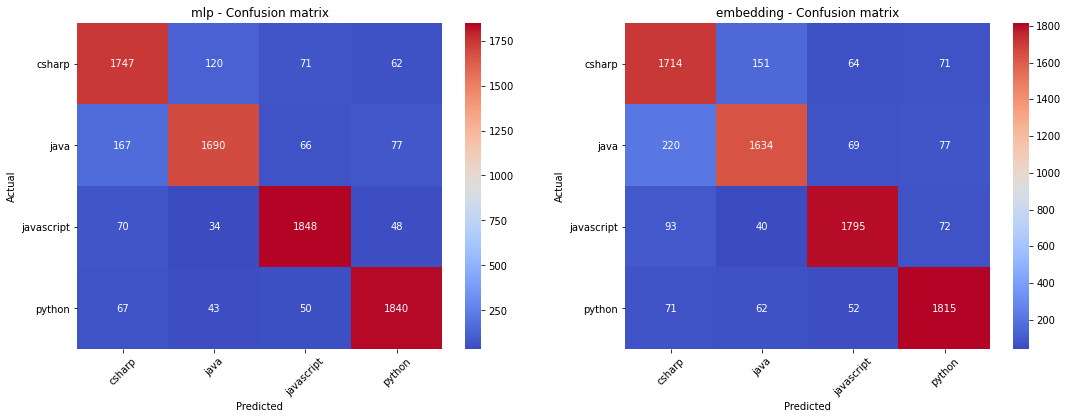

---------------------------------------- error analysis ----------------------------------------
250/250 [==============================] - 1s 3ms/step
........................................ javascript ........................................
"text box validation in blank how can i validate a text box, which only allow characters a-z &amp; a-z, numbers, space, underscore and dash character ?   text box should also not accept spanish accents and letters like -á, -é, -í, -ó, -ú, -ü, -ñ, ¿, ¡."



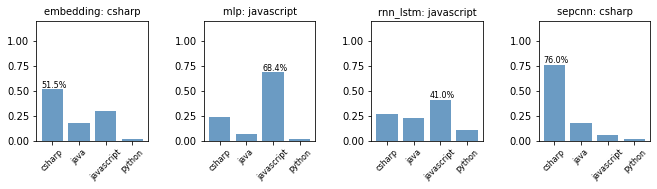

........................................ csharp ........................................
"how to find indices for all contiguous elements in an array that appear more than threshold i'm trying to find indices for all contiguous elements that occurrence more than threshold in one dimensional integer array using blank..double[] x = new double[20]{1,1,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,1,1};...i want to get indices for this x[] vector as the following for 0 values ..threshold=4..start-index[0] =2.  end-index[0] =5..start-index[1] =8.  end-index[1] =11...i try to use this code, but there is many problems in it..public void myfunc(double[] x, ref list&lt;int&gt; start, ref list&lt;int&gt; end,int matchingval,int threshold).    {.        int count = 0;.        for (int i = 0; i &lt; x.length; i++).        {.            for (int j = i+1; j &lt; threshold; j++).            {.                if (x[i] == x[j] &amp;&amp; x[i] == matchingval).                {.                    count++;.           

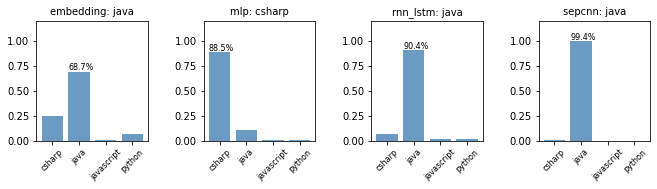

........................................ java ........................................
"when to use jaf activation i wonder if i should use it, in this example. i'm reading files, and i need to store one parameter with that file. ..according to this parameter i'm bundling files together and sending them over the wire...i came accross jaf activation framework, and i'm not sure if it is appropriate to use it in such simple example.(store 'file' into datahandler with this parameter or to make me simple holder). of course i don't know if requirments can change in the future, and i will need more. ..what do you think about it? ..my impression is that it's too much, it's difficult to get proper sources. but on the other hand it has what i need...the question could be more general as well, should i use framework which can do a lot more, if i need something really simple and i can code it quickly?..thanks in advance"



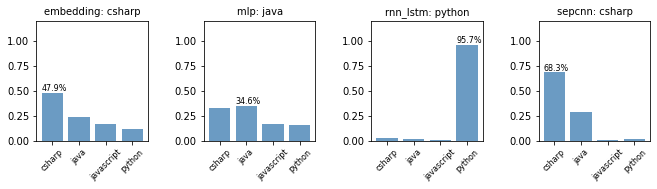

........................................ java ........................................
"how to maintain the division value without changing the output resolution when you add a number to a division product, the precision changes and the output becomes inaccurate.example:.1/(0.2352941176470588235294117647058823530)=4.2499999999999999999999999999999999989.but the output gave me an approximate value.2.25.i want the value not to change and remain without a round..thank you"



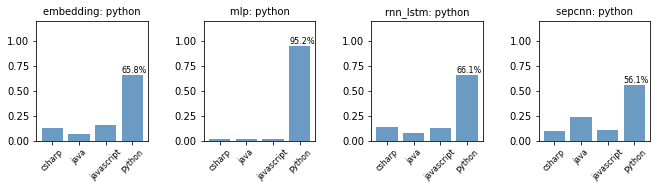

........................................ csharp ........................................
random distribution i want to know how i can create a random class that distributes data in a table randomly to 36 other tables without repetition and also how to print out those tables..am new to programming please



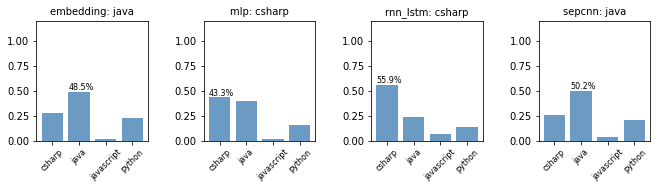

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.112182,0.9811,0.300295,0.8906,5121284,30.0
embedding,0.110117,0.9821,0.366312,0.8698,4001004,60.0
sepcnn,0.074338,0.9814,0.506712,0.8564,4043940,82.0
rnn_lstm,0.148746,0.9570,0.571635,0.8261,4321804,830.0


In [47]:
helper.model_summary(model, history=history)

### sepCNN

In [53]:
def get_sepcnn(helper,
                 blocks=1,
                 filters=64,
                 kernel_size=3,
                 embedding_dim=200,
                 dropout=None,
                 pool_size=3,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None, 
                 name='sepcnn'
                ):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
        
    input_shape = helper.data.input_shape
    num_classes = len(helper.params.classes)
    num_features = helper.params.max_features+1  
    
    model = models.Sequential(name=name)

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0],
                                   weights=[embedding_matrix],
                                   trainable=is_embedding_trainable,
                                   mask_zero=True))
    else:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0],
                                   mask_zero=True))

    for i in range(blocks):
        model.add(layers.Dropout(rate=dropout))
        if i==blocks-1: filters=filters*2
        model.add(layers.SeparableConv1D(filters=filters,
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.SeparableConv1D(filters=filters,     
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.MaxPooling1D(pool_size=pool_size))

    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(num_classes))
    helper.compile(model)  
    return model


helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_sepcnn(helper, blocks=1)
# when bolcks=2, the model can't converg
model.summary()

model_params.sepcnn.dropout=0.4
learning_rate=0.001
checkpoint_path=./checkpoints/stack_overflow_16k/sepcnn/checkpoint
Model: "sepcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
dropout_12 (Dropout)         (None, 500, 200)          0         
_________________________________________________________________
separable_conv1d_4 (Separabl (None, 500, 128)          26328     
_________________________________________________________________
separable_conv1d_5 (Separabl (None, 500, 128)          16896     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 166, 128)          0         
_________________________________________________________________
global_average_pooling1d_5 ( (None, 128)               0         
_______

2021-01-05 03:19:58,697: INFO: start training


model_params.sepcnn.epochs=10
use ModelCheckpoint(filepath=./checkpoints/stack_overflow_16k/sepcnn/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/10
250/250 [==============================] - 10s 41ms/step - loss: 1.3856 - accuracy: 0.2571 - val_loss: 1.3533 - val_accuracy: 0.3749
Epoch 2/10
250/250 [==============================] - 11s 44ms/step - loss: 0.8481 - accuracy: 0.6496 - val_loss: 0.5554 - val_accuracy: 0.7843
Epoch 3/10
250/250 [==============================] - 10s 41ms/step - loss: 0.4184 - accuracy: 0.8409 - val_loss: 0.4573 - val_accuracy: 0.8313
Epoch 4/10
250/250 [==============================] - 11s 43ms/step - loss: 0.2807 - accuracy: 0.8991 - val_loss: 0.4529 - val_accuracy: 0.8454
Epoch 5/10
250/250 [==============================] - 11s 44ms/step - loss: 0.1977 - accuracy: 0.9341 - val_loss: 0.4776 - val_ac

2021-01-05 03:21:45,885: INFO: finish training [elapsed time: 107.19 seconds]


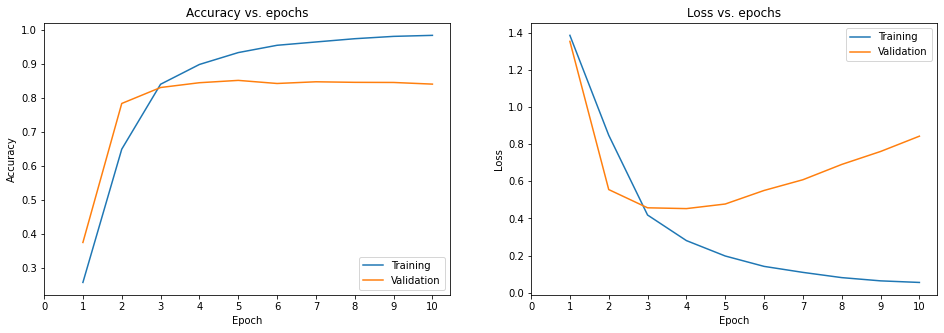

In [54]:
history = helper.train(model, batch_size=32)

---------------------------------------- evaluate ----------------------------------------
250/250 [==============================] - 2s 7ms/step - loss: 0.4776 - accuracy: 0.8522
Test loss:0.4776, Test Accuracy:85.22%
---------------------------------------- confusion matrix ----------------------------------------
250/250 [==============================] - 1s 5ms/step


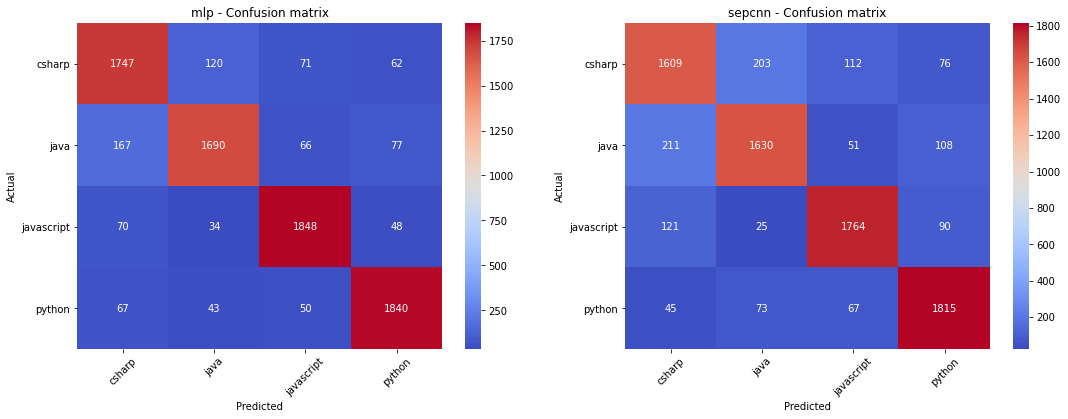

---------------------------------------- error analysis ----------------------------------------
250/250 [==============================] - 1s 5ms/step
........................................ java ........................................
"parse a log file using blank.regex.matcher i am learning blank programming. i have a cisco log:..string logline=""jul 15 21:12:41 router_provider_pe2 57: *jul 15 21:12:26.223: %ldp-5-nbrchg: ldp neighbor 10.1.1.34:0 (3) is up"";...i am trying this regular expression:..string logpattern = ""([\w]+\s[\d]+\s[\d:]+) (\d+:) ([*\w]+\s[\d]+\s[\d:]+:) (\w.+)"";...but it is not fine. could you help me?"



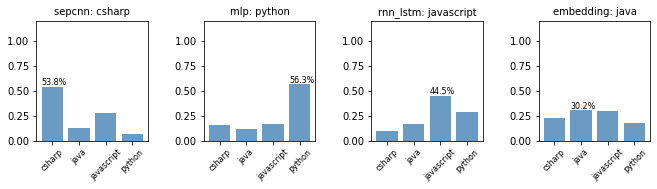

........................................ java ........................................
"blank, numbers in an array, even comes first write a blank program to rearrange all the numbers in an array, even comes before odd, only use o(1) space, and should keep relative order of even and odd numbers, for example:.input: [1, 2, 3, 4, 5].output: [2, 4, 1, 3, 5]"



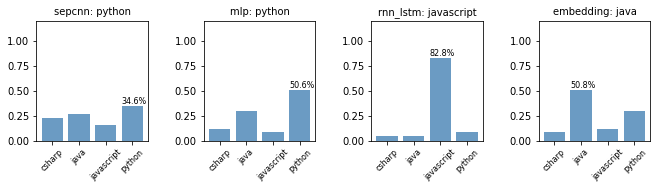

........................................ java ........................................
"tictactoe-game in blank, variable boardsize, checkwin() function is giving me trouble i am having trouble writing the checkwin() function for my tictactoe game. can someone explain to me how i can check for a win in a variable board? the win condition is if you complete a row or a column."



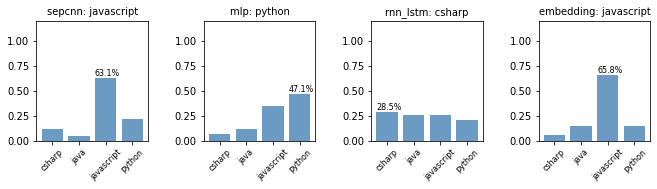

........................................ csharp ........................................
how do you do maths (or math) with numbers bigger than maxvalue in blank? .  possible duplicate:.  big integers in blank  .....i want to be able to process arbitrarily large numbers in blank..i can live with just integers.  ..are there established algorithms for this kind of thing?.or is there a good 3rd-party library?  ..i might consider changing language if there really is no good way to do it in blank.  ..thanks for any help / suggestions.



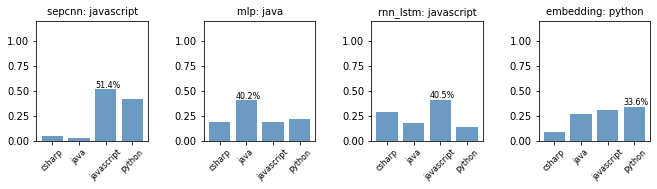

........................................ javascript ........................................
"or operator in blank message += days + "" day"" + ( days==1 ? '':'s' ) + "", "";...if my counter comes to 1 month and zero day, it writes days, of course..how can i pass a ""or"" operator into this code?..i tried:..( (days==1 ? '':'s' ) || (days==0 ? '':'s'))...and:..( days==1||0 ? '':'s' )...both of them show an s at value ""0"""



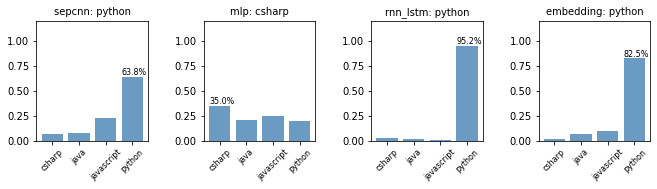

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.112182,0.9811,0.300295,0.8906,5121284,30.0
embedding,0.110117,0.9821,0.366312,0.8698,4001004,60.0
sepcnn,0.074338,0.9814,0.506712,0.8564,4043940,82.0
rnn_lstm,0.148746,0.9570,0.571635,0.8261,4321804,830.0


In [55]:
helper.model_summary(model, history=history)

## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)